This notebook assumes familiarity with the [Understanding and
controlling a maze-solving policy network](https://www.lesswrong.com/posts/cAC4AXiNC5ig6jQnc/understanding-and-controlling-a-maze-solving-net) blog post.

In [1]:
try:
    import procgen_tools
except ImportError:
    commit = ""
    get_ipython().run_line_magic(
        magic_name="pip",
        line=(
            "install -U"
            f" git+https://github.com/ulissemini/procgen-tools.git@{commit}"
        ),
    )

from procgen_tools.utils import setup

setup()  # create directory structure

from procgen_tools.imports import *
from procgen_tools import visualization, patch_utils, maze, vfield
AX_SIZE = 5.5

Already downloaded https://nerdsniper.net/mats/model_rand_region_5.pth


# Generating top-right vectors
We're going to generate a new kind of behavior-modifying activation-space vector. This vector will be a top-right vector. We compute it by diffing activations across two environments: one where the top-right corner is considerably higher up, and the original one.

In [2]:
@interact
def top_right_maze_pairs(seed=IntSlider(value=0, min=0, max=100)):
    venv = maze.get_top_right_venv_pair(seed=seed)
    fig, axs = plt.subplots(1, 2, figsize=(AX_SIZE, AX_SIZE * 2))
    for idx in (0, 1):
        visualization.visualize_venv(
            venv=venv,
            idx=idx,
            ax=axs[idx],
            ax_size=AX_SIZE,
            render_padding=True,
        )

    # Title each axis
    axs[0].set_title("Path to top-right")
    axs[1].set_title("Original maze")

    plt.show()

interactive(children=(IntSlider(value=0, description='seed'), Output()), _dom_classes=('widget-interact',))

Peli Grietzer noticed that when the top-right-most reachable square is closer to the absolute
top-right, the agent seems to have an increased tendency to go to there.
The next interactive shows this effect.

(Arrow thickness is a technical artifact here. Just look at arrow directions.)

In [3]:
@interact
def top_right_vf_pairs(seed=IntSlider(value=0, min=0, max=100)):
    venv = maze.get_top_right_venv_pair(seed=seed)
    fig, axs = plt.subplots(1, 2, figsize=(AX_SIZE, AX_SIZE * 2))
    for idx in (0, 1):
        vfield = visualization.vector_field(venv, policy, idx=idx)
        visualization.plot_vf(vfield, ax=axs[idx], render_padding=True)

    # Title each axis
    axs[0].set_title("Path to top-right")
    axs[1].set_title("Original maze")

    plt.show()

interactive(children=(IntSlider(value=0, description='seed'), Output()), _dom_classes=('widget-interact',))

As in the cheese vector case, we get a "top right vector" by:
1. Running a forward pass on the "path to top-right" maze, and another
   forward pass on the original maze, and storing the activations for
   each. In both situations, the mouse is located at the starting square.
2. About halfway through the network (at the second Impala block's
   first residual add), take the difference in channel activation tensors to be
   the "top right vector."

We then add `coeff*top_right_vector` to halfway through future forward
passes, where the input observations differ due to different mouse
locations.

# The effect of adding the top-right vector
The top-right vector is highly effective at increasing the probability
the agent goes to the top-right corner. 

In [4]:
@interact
def examine_tr_patch(
    seed=IntSlider(min=0, max=100, step=1, value=0),
    coeff=FloatSlider(min=-5, max=5, step=0.1, value=1),
):
    venv_pair = maze.get_top_right_venv_pair(seed=seed)
    patch = patch_utils.patch_from_venv_pair(
        venv_pair, layer_name=default_layer, hook=hook, coeff=coeff
    )

    # Show the effect of the patch
    target_venv = maze.create_venv(
        num=1, start_level=seed, num_levels=1
    )
    fig, axs, info = patch_utils.compare_patched_vfields(
        target_venv,
        patch,
        hook,
        render_padding=False,
        ax_size=AX_SIZE,
        show_components=False,
    )
    fig.suptitle(f"Seed: {seed}, top-right vector added with coefficient {coeff:.1f}", fontsize=20, y=.94)
    plt.show(fig)


interactive(children=(IntSlider(value=0, description='seed'), FloatSlider(value=1.0, description='coeff', max=…

For example, in maze seed 0, the original trained network doesn't go to the
top-right corner:
![](https://res.cloudinary.com/lesswrong-2-0/image/upload/f_auto,q_auto/v1/mirroredImages/cAC4AXiNC5ig6jQnc/o24edwffjw5id3xexkjp)

Adding the top-right vector fixes this issue:

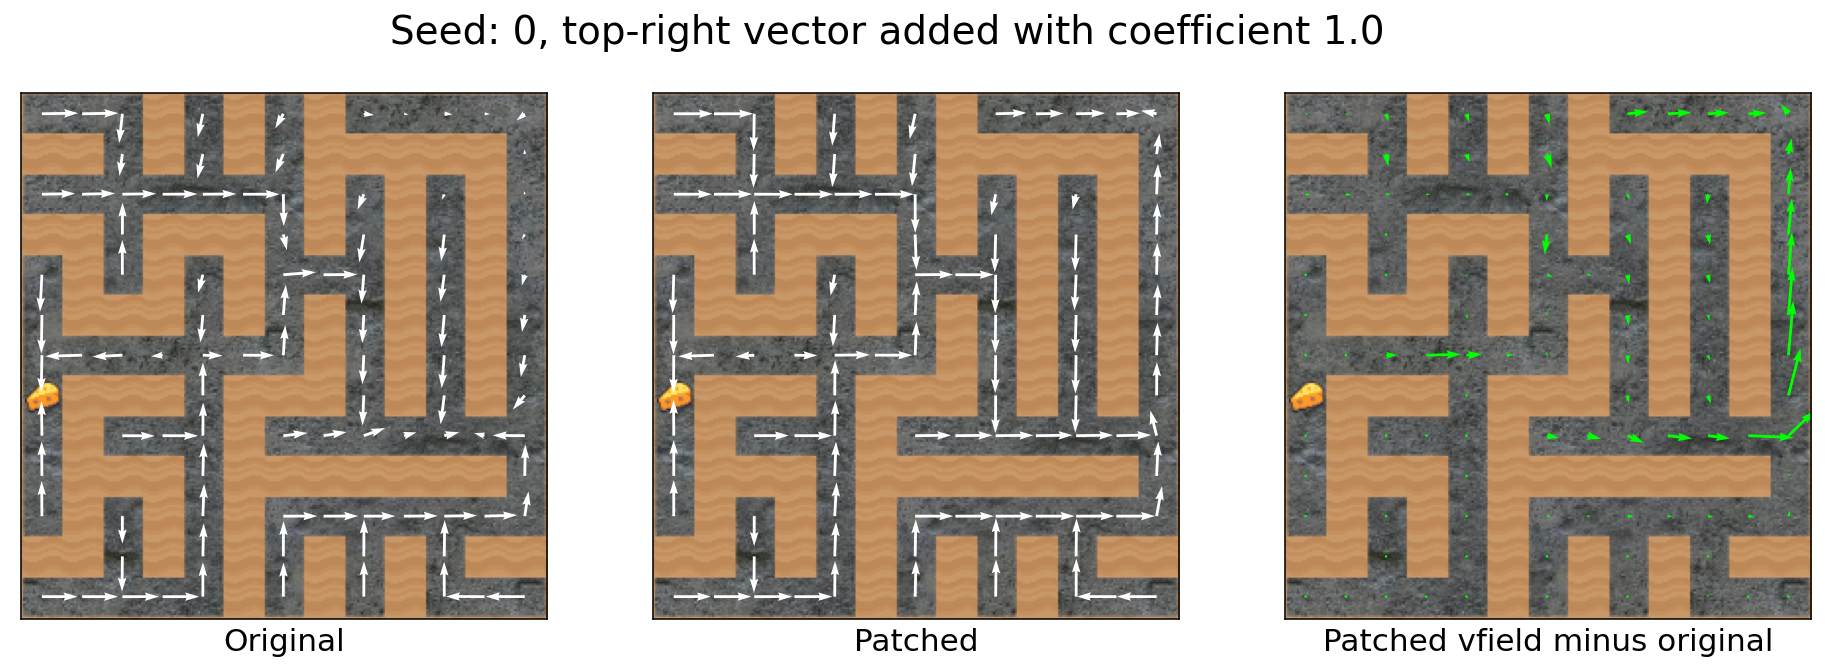

In [5]:
examine_tr_patch(coeff=1.0, seed=0)

Likewise for seed 2:

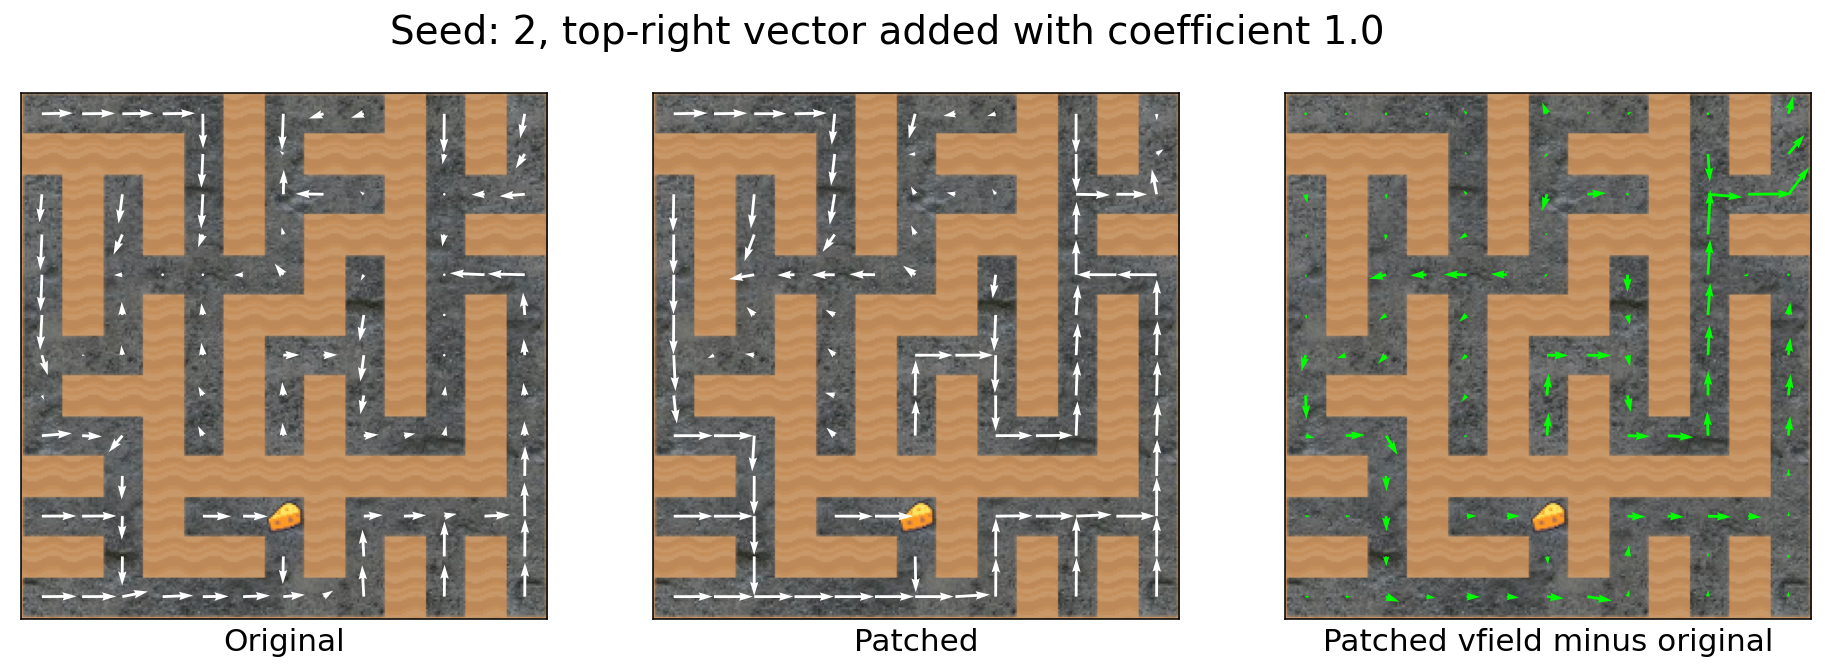

In [6]:
examine_tr_patch(coeff=1.0, seed=2)

Also, after looking through about half a dozen examples, small mazes
(like seed 1)
seem far less affected by the top-right
vector. 

In [ ]:
examine_tr_patch(coeff=1.0, seed=1)

There are some exceptions, like seed 43,609, but they are rare.

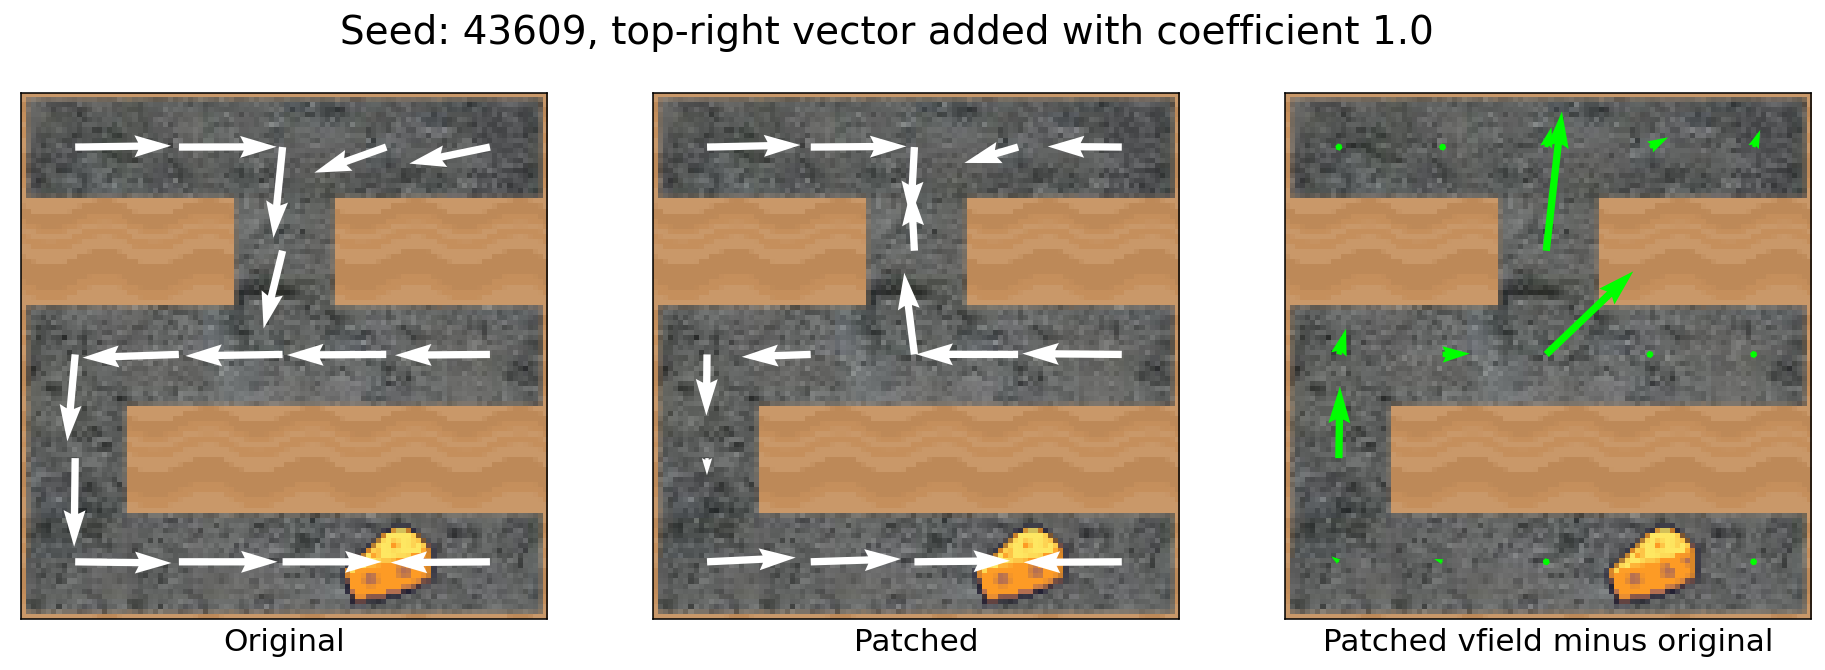

In [23]:
examine_tr_patch(coeff=1.0, seed=43609)

You can look for yourself, without cherry-picking. The following
function generates small mazes. Click the "generate new maze" button to
get another random seed. 

In [21]:
fig_out = widgets.Output()
def show_small_maze(max_size:int=6):
    """ Show the top-right vector diff for a randomly generated maze of
    size less than or equal to max_size. """
    # Generate the seed and the top-right patch
    seed = maze.rand_seed_with_size(max_size=max_size)
    venv_pair = maze.get_top_right_venv_pair(seed=seed)
    patch = patch_utils.patch_from_venv_pair(
        venv_pair, layer_name=default_layer, hook=hook, coeff=1
    )

    # Show the effect of the patch
    venv = maze.create_venv(num=1, start_level=seed, num_levels=1)
    fig, axs, info = patch_utils.compare_patched_vfields(
        venv,
        patch,
        hook,
        render_padding=False,
        ax_size=AX_SIZE,
        show_components=False,
    )
    fig.suptitle(f"Seed: {seed}, top-right vector added with coefficient {1.0:.1f}", fontsize=20, y=.94)

    fig_out.clear_output(wait=True)
    with fig_out:     
        plt.show(fig)


In [22]:
display(fig_out)
show_small_maze()

button = widgets.Button(description='Generate new plots')
button.on_click(lambda _: show_small_maze(max_size=6))
display(button)

Output()

Button(description='Generate new plots', style=ButtonStyle())

The agent also tends to be less [retargetable](https://www.lesswrong.com/posts/cAC4AXiNC5ig6jQnc/understanding-and-controlling-a-maze-solving-net#Retargeting_the_agent_to_maze_locations) in smaller mazes.
We don't know why.

## Adding the top-right vector with different strengths
Varying the `coefficient` will vary the effect. However, very large
coefficients will screw up cognition.

## Subtracting the top-right vector has little effect

For some reason, subtracting the top-right vector has very little
effect. (Similarly, _adding_ the cheese vector had little effect.)

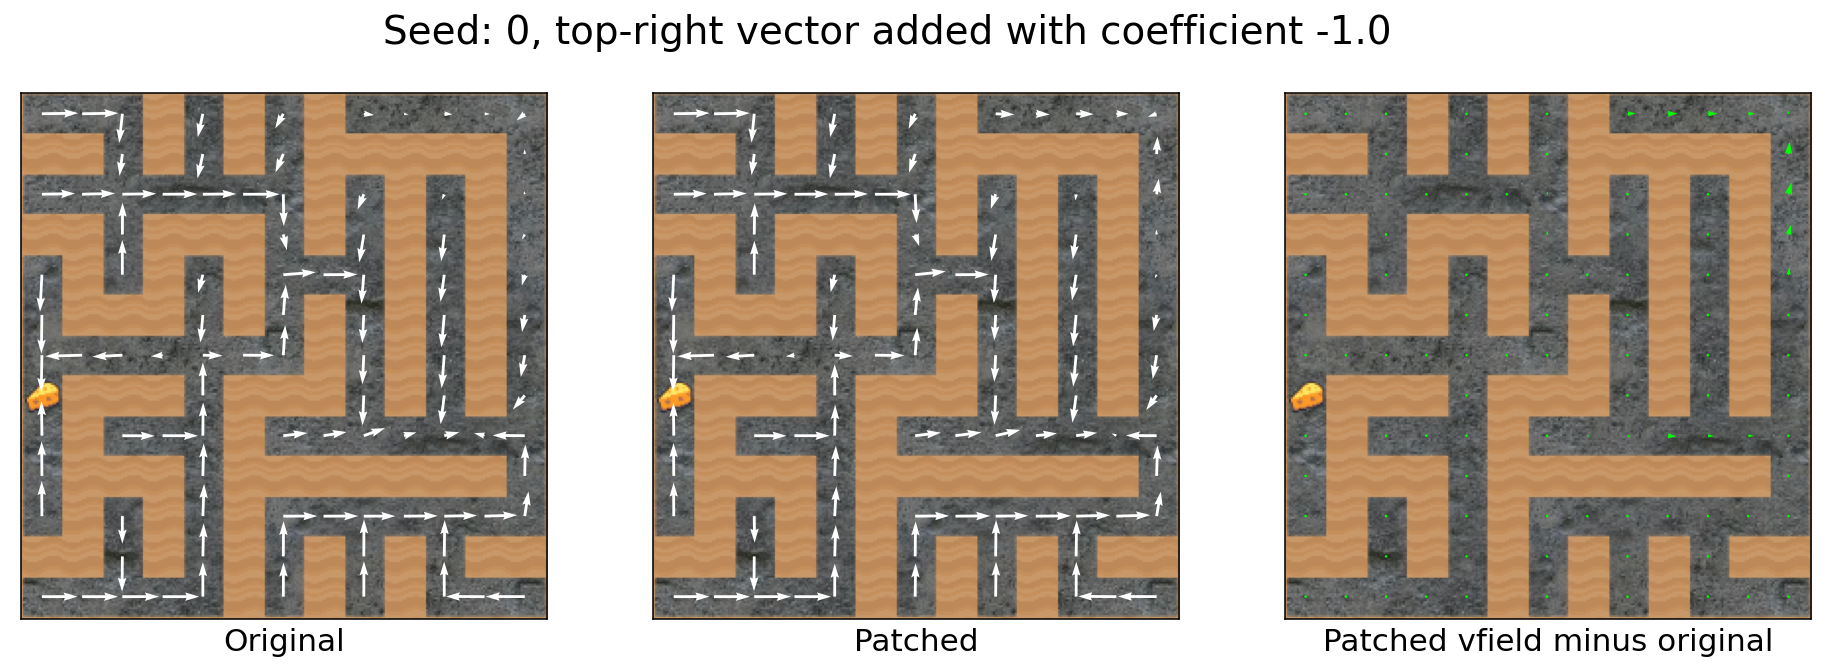

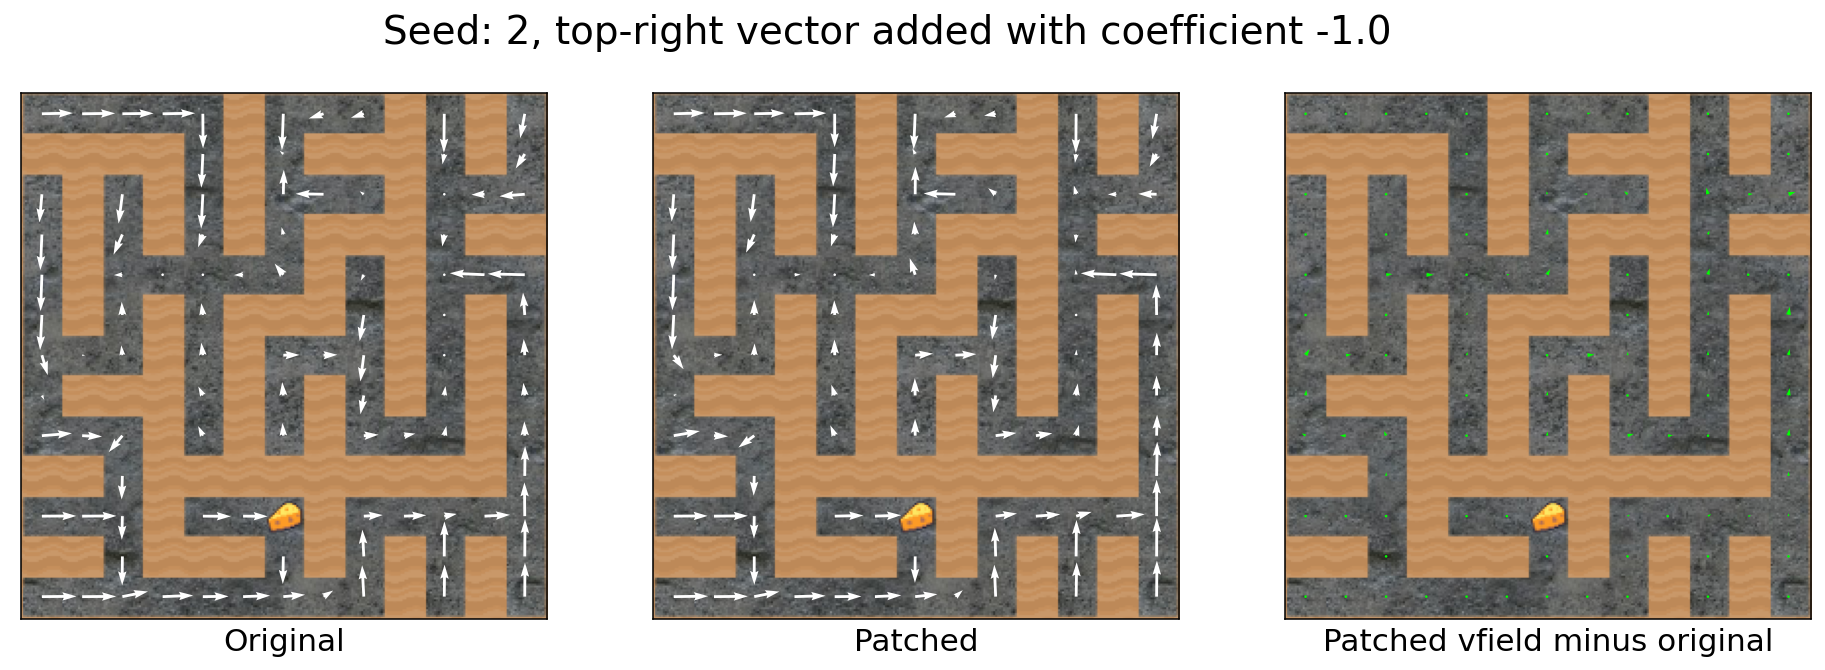

In [8]:
examine_tr_patch(coeff=-1.0, seed=0)
examine_tr_patch(coeff=-1.0, seed=2)

In [9]:
@interact
def examine_tr_patch_transfer(
    target_seed=IntSlider(min=0, max=100, step=1, value=0),
    coeff=FloatSlider(min=-5, max=5, step=0.1, value=1),
):
    venv_pair = maze.get_top_right_venv_pair(seed=0)
    patch = patch_utils.patch_from_venv_pair(
        venv_pair, layer_name=default_layer, hook=hook, coeff=coeff
    )

    # Show the effect of the patch
    target_venv = maze.create_venv(
        num=1, start_level=target_seed, num_levels=1
    )
    fig, axs, info = patch_utils.compare_patched_vfields(
        target_venv,
        patch,
        hook,
        render_padding=False,
        ax_size=AX_SIZE,
        show_components=False,
    )
    plt.show(fig)


interactive(children=(IntSlider(value=0, description='target_seed'), FloatSlider(value=1.0, description='coeff…

In [10]:
@interact
def compose_patches(
    target_seed=IntSlider(min=0, max=100, step=1, value=0),
    top_right_coeff=FloatSlider(min=-5, max=5, step=0.1, value=1),
    use_cheese_vector=Checkbox(value=True),
    use_tr_vector=Checkbox(value=True),
):
    patch_list = []
    if use_tr_vector:
        tr_venv_pair = maze.get_top_right_venv_pair(seed=target_seed)
        tr_patch = patch_utils.patch_from_venv_pair(
            tr_venv_pair,
            layer_name=default_layer,
            hook=hook,
            coeff=top_right_coeff,
        )
        patch_list.append(tr_patch)

    if use_cheese_vector:
        cheese_diff_values = patch_utils.cheese_diff_values(
            seed=target_seed, layer_name=default_layer, hook=hook
        )
        cheese_patch = patch_utils.get_values_diff_patch(
            values=cheese_diff_values, coeff=-1, layer_name=default_layer
        )
        patch_list.append(cheese_patch)

    patch = patch_utils.compose_patches(*patch_list) if patch_list else {}

    target_venv = maze.create_venv(
        num=1, start_level=target_seed, num_levels=1
    )
    fig, axs, info = patch_utils.compare_patched_vfields(
        target_venv, patch, hook, render_padding=False, ax_size=AX_SIZE
    )

    # Title which patches we're using
    title = "Patches: "
    if use_tr_vector:
        title += "Top-right vector, "
    if use_cheese_vector:
        title += "Cheese vector, "
    title = title[:-2]  # Remove trailing comma
    fig.suptitle(title, fontsize=20)

    plt.show(fig)

interactive(children=(IntSlider(value=0, description='target_seed'), FloatSlider(value=1.0, description='top_r…